In [ ]:
pip install numpy==1.22

In [ ]:
pip install pandas

In [ ]:
pip install shap

In [ ]:
pip install seaborn

In [ ]:
pip install optuna

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [88]:
import pandas as pd
import numpy as np
import copy
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from optuna.trial import Trial
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, LeaveOneOut, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import preprocessing

In [89]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
filename = './머신러닝데이터.xlsx'

In [91]:
# Imputation한 데이터를 불러온다
scoring_transition_1 = pd.read_excel(filename, sheet_name='scoring_result_merged', engine='openpyxl')
scoring_transition_0 = pd.read_excel(filename, sheet_name='scoring_origin', engine='openpyxl')
task_completion_time = pd.read_excel(filename, sheet_name='task_completion_time_mean_imput', engine='openpyxl')
sms_reply = pd.read_excel(filename, sheet_name='SMS_reply', engine='openpyxl')
weather_searching_site_region = pd.read_excel(filename, sheet_name='weather_searching_사이트주소', engine='openpyxl')

# 모든 Feature List
sms_reply, weather_searching_사이트주소는 feature 리스트가 같습니다

In [92]:
# scoring = ['Routine_Screen_Unlock_Pattern', 'Routine_Phone_Register', 'Routine_Phone_Receive', 'Routine_SMS_Reply', 'Routine_Camera', 
# 'Routine_Location_Searching', 'Routine_Weather_Searching', 'Routine_Transfer', 'Routine_Location_Switching', 'Routine_Weather_Switching', 
# 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 'Transition_Camera', 'Transition_Location_Searching', 
# 'Transition_Weather_Searching', 'Transition_Transfer', 'Transition_Location_Switching', 'Transition_Weather_Switching', 'Result_Phone_Register', 
# 'Result_Phone_Receive', 'Result_SMS_Reply', 'Result_Camera', 'Result_Location_Searching', 'Result_Weather_Searching', 'Result_Transfer', 
# 'Result_Location_Switching', 'Result_Weather_Switching', 'routine_sum_trial', 'transition_sum_trial', 'result_sum_trial', 'all_sum_trial']

# task = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 'phone_register_total_time_nt', 
# 'phone_register_screen_unlocking_time', 'phone_register_sms_start_time', 'phone_register_instruction_check_time', 'phone_register_total_time', 
# 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_receive_noti response', 'phone_receive_total_time_nt', 'phone_receive_total_time', 
# 'phone_receive_missing_call_time_1', 'phone_receive_missing_call_time_2', 'sms_reply_noti_response_time', 'sms_reply_total_time_nt', 'sms_reply_compeltion_time', 
# 'sms_reply_total_time', 'camera_noti_response', 'camera_total_time_nt', 'camera_instruction_check_time', 'camera_total_time', 'camera_taken_time', 
# 'camera_gallery_delete_time', 'transfer_noti_response_time', 'transfer_total_time_nt', 'transfer_instruction_check_time', 'transfer_total_time', 
# 'transfer_usage_time', 'transfer_share_time', 'weather_searching_noti_response', 'weather_searching_total_time_nt', 'weather_searching_instruction_check_time', 
# 'weather_searching_total_time', 'weather_information_searching_time', 'weather_information_sharing_time', 'weather_switching_notification_response_time', 
# 'weather_switching_total_time_nt', 'weather_switching_instruction_check_time', 'weather_switching_total_time', 
# 'weather_switching_first_searching_keyword_typing_time', 'weather_switching_second_searching_keyword_typing_time', 
# 'weather_switching_information_searching_time', 'weather_switching_information_sharing_texting_time', 'location_searching_noti_response_time', 
# 'location_searching_total_time_nt', 'location_searching_instruction_check_time', 'location_searching_total_time', 'location_searching_food_typing_time', 
# 'location_searching_foodtyping_mapfinding_time', 'location_searching_mapfinding_time', 'location_searching_route_sharing_texting_time', 
# 'location_switching_notification_response', 'location_switching_total_time_nt', 'location_switching_instruction_check', 'location_switching_total_time', 
# 'location_switching_first_map_typing_time', 'location_switching_second_map_typing_time', 'location_switching_map_finding_time', 
# 'location_switching_map_route_sharing_time']

# sms_and_ws = ['average intercharacter time', 'std intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
# 'total_time (S)', 'total_count', 'IS (C+IF+INF+F)', 'backspace (F)', 'C', 'IF', 'INF', 'Shift', 'ISø (IS+S)', 'T (total_count-F)', 'WPS', 'WPM', 'AdjWPS', 
# 'AdjWPM', 'CPS', 'KSPS', 'GPS', 'KSPC', 'GPC', 'MSD', 'COER', 'UER', 'TER', 'CE', 'PC', 'UB', 'WB', 'CPC']

In [93]:
# BAC column만 가져온다(Label)
y = scoring_transition_1['BAC']

# Participant, BAC column을 제거한다
scoring_transition_1 = scoring_transition_1.drop(['Participant', 'BAC'], axis=1)
scoring_transition_0 = scoring_transition_0.drop(['Participant', 'BAC'], axis=1)
task_completion_time = task_completion_time.drop(['Participant', 'BAC'], axis=1)
sms_reply = sms_reply.drop(['Participant', 'BAC'], axis=1)
weather_searching_site_region = weather_searching_site_region.drop(['Participant', 'BAC'], axis=1)

In [94]:
# 라벨 3개용 features
# 각 데이터별로 필요한 column들만 뽑는다
scoring_transition_1_columns = []

scoring_transition_0_columns = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
                                'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial', 'Result_Phone_Register', 'Result_Phone_Receive', 'Result_SMS_Reply',
                                'Result_Camera', 'Result_Weather_Searching', 'Result_Transfer', 'result_sum_trial']

task_completion_time_columns = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time','phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

In [95]:
# 라벨을 2개용 features
scoring_transition_1_columns_two_label = []

scoring_transition_0_columns_two_label = ['Routine_Screen_Unlock_Pattern', 'Transition_Phone_Register', 'Transition_Phone_Receive', 'Transition_SMS_Reply', 
                                        'Transition_Camera', 'Transition_Weather_Searching', 'Transition_Transfer', 'transition_sum_trial', 'Result_Phone_Register', 'Result_Phone_Receive', 'Result_SMS_Reply',
                                        'Result_Camera', 'Result_Weather_Searching', 'Result_Transfer', 'result_sum_trial']

task_completion_time_columns_two_label = ['average_noti_response_app_start', 'median_noti_response_app_start', 'phone_register_noti_response', 
'phone_register_screen_unlocking_time', 'phone_register_phone_number_register_time', 'phone_register_call_time', 'phone_register_total_time', 
'phone_receive_total_time','phone_receive_missing_call_time_2', 'sms_reply_compeltion_time', 'sms_reply_total_time', 
'camera_taken_time', 'camera_gallery_delete_time', 'camera_total_time', 'transfer_usage_time', 'transfer_share_time', 'transfer_total_time', 
'weather_information_searching_time', 'weather_information_sharing_time', 'weather_searching_total_time']

sms_reply_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns_two_label = ['average intercharacter time', 'median intercharacter time', 'min intercharacter time', 'max intercharacter time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

In [96]:
# 위에서 정한 feature들로 각각의 데이터 프레임을 생성한다
scoring_transition_1_df = scoring_transition_1[scoring_transition_1_columns]
scoring_transition_0_df = scoring_transition_0[scoring_transition_0_columns]
task_completion_time_df = task_completion_time[task_completion_time_columns]
sms_reply_df = sms_reply[sms_reply_columns]
weather_searching_site_region_df = weather_searching_site_region[weather_searching_site_region_columns]

scoring_transition_1_df_two_label = scoring_transition_1[scoring_transition_1_columns_two_label]
scoring_transition_0_df_two_label = scoring_transition_0[scoring_transition_0_columns_two_label]
task_completion_time_df_two_label = task_completion_time[task_completion_time_columns_two_label]
sms_reply_df_two_label = sms_reply[sms_reply_columns_two_label]
weather_searching_site_region_df_two_label = weather_searching_site_region[weather_searching_site_region_columns_two_label]

# feature명 수정하기
위에서 적은 feature명을 그대로 복사해서 가져온 다음 바꾸려는 feature만 수정하면 됩니다

In [97]:
# 라벨 3개용 features의 feature명을 수정한다!
scoring_transition_1_columns = []

scoring_transition_0_columns = ['screen_unlock_trial', 'phone_register_transition', 'phone_receive_transition', 'SMS_reply_transition', 
'camera_transition', 'info_sear_transition', 'banking_transition', 'total_task_sum_transition', 'phone_register_accuracy', 'phone_receive_accuracy', 'SMS_reply_accuracy',
                                        'camera_accuracy', 'weather_searching_accuracy', 'transfer_accuracy', 'total_task_sum_accuracy']

task_completion_time_columns = ['average_noti_response_time', 'median_noti_response_time', 'screen_on_after_noti_response', 
'screen_Unlock_Time', 'phone_number_register_time', 'phone_call_time', 'phone_call_register_task_total_time', 
'phone_receive_task_total_time','phone_receive_time', 'sms_reply_compeltion_time', 'sms_reply_task_total_time', 
'camera_taken_time', 'image_delete_time', 'camera_task_total_time', 'banking_usage_time', 'transfer_share_time', 'banking_task_total_time', 
'info_searching_time', 'info_sharing_time', 'info_search_share_task_total_time']

sms_reply_columns = ['average_intercharacter_time', 'median_intercharacter_time', 'min_intercharacter_time', 'max_intercharacter_time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns = ['average_intercharacter_time', 'median_intercharacter_time', 'min_intercharacter_time', 'max_intercharacter_time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

scoring_transition_1_df.columns = scoring_transition_1_columns
scoring_transition_0_df.columns = scoring_transition_0_columns
task_completion_time_df.columns = task_completion_time_columns
sms_reply_df.columns = sms_reply_columns
weather_searching_site_region_df.columns = weather_searching_site_region_columns

In [98]:
# 라벨을 2개용 features의 feature명을 수정한다!
scoring_transition_1_columns_two_label = []

scoring_transition_0_columns_two_label = ['screen_unlock_trial', 'phone_register_transition', 'phone_receive_transition', 'SMS_reply_transition', 
'camera_transition', 'info_sear_transition', 'banking_transition', 'total_task_sum_transition', 'phone_register_accuracy', 'phone_receive_accuracy', 'SMS_reply_accuracy',
                                        'camera_accuracy', 'weather_searching_accuracy', 'transfer_accuracy', 'total_task_sum_accuracy']

task_completion_time_columns_two_label = ['average_noti_response_time', 'median_noti_response_time', 'screen_on_after_noti_response', 
'screen_Unlock_Time', 'phone_number_register_time', 'phone_call_time', 'phone_call_register_task_total_time', 
'phone_receive_task_total_time','phone_receive_time', 'sms_reply_compeltion_time', 'sms_reply_task_total_time', 
'camera_taken_time', 'image_delete_time', 'camera_task_total_time', 'banking_usage_time', 'transfer_share_time', 'banking_task_total_time', 
'info_searching_time', 'info_sharing_time', 'info_search_share_task_total_time']

sms_reply_columns_two_label = ['average_intercharacter_time', 'median_intercharacter_time', 'min_intercharacter_time', 'max_intercharacter_time', 
'CPS', 'KSPS', 'GPS', 'COER', 'UER', 'TER', 'UB', 'WB']

weather_searching_site_region_columns_two_label = ['average_intercharacter_time', 'median_intercharacter_time', 'min_intercharacter_time', 'max_intercharacter_time', 
'CPS', 'KSPS', 'COER', 'UB', 'WB']

scoring_transition_1_df_two_label.columns = scoring_transition_1_columns_two_label
scoring_transition_0_df_two_label.columns = scoring_transition_0_columns_two_label
task_completion_time_df_two_label.columns = task_completion_time_columns_two_label
sms_reply_df_two_label.columns = sms_reply_columns_two_label
weather_searching_site_region_df_two_label.columns = weather_searching_site_region_columns_two_label

In [99]:
# sms reply와 weather searching 사이트 주소의 feature명이 똑같으므로 feature명을 수정한다
sms_reply_df_columns = ['sms_' + col_name for col_name in sms_reply_df.columns] # sms reply feature 이름 앞에 sms_를 붙인다
weather_searching_site_region_df_columns = ['ws_' + col_name for col_name in weather_searching_site_region_df.columns] # ws feature 이름 앞에 ws_를 붙인다

sms_reply_df.columns = sms_reply_df_columns # 수정된 sms reply feature명을 적용한다
weather_searching_site_region_df.columns = weather_searching_site_region_df_columns # 수정된 ws feature명을 적용한다

# 위와 동일하게 작동한다
sms_reply_df_two_label_columns = ['sms_' + col_name for col_name in sms_reply_df_two_label.columns]
weather_searching_site_region_df_two_label_columns = ['ws_' + col_name for col_name in weather_searching_site_region_df_two_label.columns]

sms_reply_df_two_label.columns = sms_reply_df_two_label_columns
weather_searching_site_region_df_two_label.columns = weather_searching_site_region_df_two_label_columns

### merged_df : Label 3개인 데이터 집합
### merged_df_two_label : Label 2개인 데이터 집합

In [100]:
# 필요한 데이터 프레임들을 합친다
merged_df_list = [scoring_transition_1_df, scoring_transition_0_df, task_completion_time_df, sms_reply_df, weather_searching_site_region_df]
merged_df_list_two_label = [scoring_transition_1_df_two_label, scoring_transition_0_df_two_label, task_completion_time_df_two_label, 
sms_reply_df_two_label, weather_searching_site_region_df_two_label]

merged_df = pd.concat(merged_df_list, axis=1)
merged_df_two_label = pd.concat(merged_df_list_two_label, axis=1)

In [101]:
# Categorical 데이터에 대해서 인코딩한다
# 어떤 데이터가 Categorical 데이터인가?

# 라벨에 대해서 인코딩한다
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

### N : 3개 라벨에 대한 feature 개수 / M : 2개 라벨에 대한 feature 개수
merged_df.shape = (360, N), y.shape = (360, 1), 라벨 수: 3 </br>
merged_df_two_label.shape = (360, M), changed_label.shape = (360, 1), 라벨 수: 2 </br>
changed_df.shape = (240, M), changed_y.shape = (240, 1), 라벨 수: 2 </br>

In [102]:
# 라벨에 대해서 인코딩한다(0 -> 0, 0.06 -> 1, 0.09 -> 2)
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

# 3개의 라벨을 2개의 라벨로 바꾼다
changed_label = copy.deepcopy(y)

for i in range(len(changed_label)):
    if changed_label[i] == 1:
        changed_label[i] = 0

for i in range(len(changed_label)):
    if changed_label[i] == 2:
        changed_label[i] = 1

# 라벨 0과 라벨 0.06의 평균을 구해서 하나의 라벨로 만든다
temp_y = pd.Series(y, name='Label')
temp_df = pd.concat([temp_y, merged_df_two_label], axis=1)

changed_df = pd.DataFrame(columns=temp_df.columns)

num = 0
for row_idx in range(0, len(temp_df), 9):
    for i in range(3):
        changed_df.loc[num] = (temp_df.loc[row_idx + i] + temp_df.loc[row_idx + i + 3])/2
        num += 1
    for i in range(3):
        changed_df.loc[num] = temp_df.loc[row_idx + 6 + i]
        num += 1

changed_y = changed_df['Label']
changed_df = changed_df.drop(['Label'], axis=1)
changed_y = encoder.fit_transform(changed_y)

# 3 Labels, 2 Labels(just change), 2 Labels(average)에 대한 데이터
label_processing = ['3 Labels', '2 Labels(just change)', '2 Labels(average)']
data_list = [(merged_df, y), (merged_df_two_label, changed_label), (changed_df, changed_y)]

In [103]:
scaler_list = {
    'minmax': MinMaxScaler(),
    'maxabs': MaxAbsScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

label_list = {
    'three_label': data_list[0],
    'two_label_changed': data_list[1],
    'two_label_average': data_list[2]
}

# scaler_name과 label_name을 인자로 받아서 해당하는 X, y를 반환한다
def getXy(scaler_name, label_name):
    if scaler_name not in scaler_list.keys() and scaler_name != 'no_scale':
        raise ValueError("scaler_name must be 'minmax' or 'maxabs' or 'standard' or 'robust' or 'no_scale!")

    if label_name not in label_list.keys():
        raise ValueError("label_name must be 'three_label' or 'two_label_changed' or 'two_label_average'!")

    X, y = label_list[label_name]

    if scaler_name != 'no_scale':
        scaler = scaler_list[scaler_name]
        df = X.copy()

        df[df.columns] = scaler.fit_transform(df[df.columns])

        X = df
        X[X.columns] = scaler.fit_transform(X[X.columns])
    
    return (X, y)

# 어떤 label의 데이터로 돌릴 것인지, 어떤 scaler를 적용할 것인지, inner loop에서 어떤 cv 방법을 적용할 것인지, Stratified K-fold의 K를 정한다

### scaler_name = 'minmax' or 'maxabs' or 'standard' or 'robust' or 'no_scale'
### label_name = 'three_label' or 'two_label_changed' or 'two_label_average'
### cv_method = 'loso' or 'k_fold'
### n_fold = 39(default)

In [104]:
scaler_name = 'no_scale'
label_name = 'three_label'
cv_method = 'k_fold'
n_fold = 13

X, y = getXy(scaler_name=scaler_name, label_name=label_name)

# Optuna의 반복 수를 설정한다

In [105]:
n_trials = 100

In [106]:
def NestedCVwithOptuna(objective, clf, clf_name):
    metric_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score'])

    # 클래스가 몇 개인지 확인한다
    class_nums = len(set(y))
    print('class_nums : ', class_nums)
    n_splits = 40
    kfold = KFold(n_splits=n_splits)

    mean_accuracy = 0
    mean_precision = 0
    mean_recall = 0
    mean_f1 = 0
    mean_roc_auc = 0
    
    list_shap_values = list()
    list_test_sets = list()

    for num, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y[train_idx], y[val_idx]
        
        classifier = clone(clf)
        # Bayesian Optimization을 진행한다
        sampler = TPESampler()

        study = optuna.create_study(direction='maximize', sampler=sampler, study_name=f'{clf_name} Study')
        study.optimize(objective(X_train, y_train), n_trials=n_trials)

        best_params = study.best_params
        print('Optuna Best score : ', study.best_value)
        print('Best parameters : ', best_params)


        if clf_name == 'lightgbm':
            best_clf = LGBMClassifier(**best_params, random_state=42)
        elif clf_name == 'xgboost':
            best_clf = XGBClassifier(**best_params, random_state=42)
        elif clf_name == 'randomforest':
            best_clf = RandomForestClassifier(**best_params, random_state=42)
        elif clf_name == 'gbm':
            best_clf = GradientBoostingClassifier(**best_params, random_state=42)
        
        best_clf.fit(X_train, y_train)

        y_pred = best_clf.predict(X_val)
        y_pred_prob = best_clf.predict_proba(X_val)

        # 개별 performance metric을 구한다
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='macro')
        recall = recall_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, average='macro')
        if class_nums > 2:
            roc_auc = roc_auc_score(y_val, y_pred_prob, average='macro', multi_class='ovr')
        else:
            roc_auc = roc_auc_score(y_val, y_pred)
        
        # 개별 performance metric을 데이터 프레임으로 저장한다
        metric_df.loc[len(metric_df)] = [f'model_{num+1}', accuracy, precision, recall, f1, roc_auc]

        # 평균 performance metric을 구한다
        mean_accuracy += accuracy / n_splits
        mean_precision += accuracy / n_splits
        mean_recall += recall / n_splits
        mean_f1 += f1 / n_splits
        mean_roc_auc += roc_auc / n_splits

        print('test accuracy : ', accuracy)

        # explaining model
        explainer = shap.TreeExplainer(best_clf)
        shap_values = explainer.shap_values(X_val)
        
        list_shap_values.append(shap_values)
        list_test_sets.append(val_idx)

    print()
    print('mean accuracy : ', mean_accuracy)
    print('mean precision : ', mean_precision)
    print('mean recall : ', mean_recall)
    print('mean f1 : ', mean_f1)
    print('mean roc_auc : ', mean_roc_auc)
    print()

    metric_df.loc[len(metric_df)] = ['mean', mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc]

    # combining results from all iterations
    if class_nums > 2 or clf_name == 'lightgbm' or clf_name == 'randomforest':
        test_set = list_test_sets[0]
        shap_values = np.array(list_shap_values[0])
        for i in range(1,len(list_test_sets)):
            test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
            shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
        #bringing back variable names    
        X_test = pd.DataFrame(X.loc[test_set], columns=X.columns)
    else:
        test_set = list_test_sets[0]
        shap_values = np.array(list_shap_values[0])
        for i in range(1,len(list_test_sets)):
            test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
            shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
        #bringing back variable names    
        X_test = pd.DataFrame(X.loc[test_set], columns=X.columns)

    return (shap_values, X_test, metric_df)

## Accuracy가 아닌 다른 metric을 기준으로 Optuna을 하려면 precision ~ roc_auc 주석 중 하나를 풀고 return 해주면 됩니다

In [107]:
def InnerCrossValidation(clf, X, y, cv_method, n_fold=39):
    class_nums = len(set(y))
    if cv_method == 'loso':
        kfold = KFold(n_splits=39)
        splits = kfold.split(X)
    elif cv_method == 'k_fold':
        stratified_kfold = StratifiedKFold(n_splits=n_fold)
        splits = stratified_kfold.split(X, y)
    else:
        raise ValueError("cv_method must be 'loso' or 'k_fold'!")
    
    train_X_len = len(X)
    if train_X_len % n_fold != 0:
        raise ValueError(f"{train_X_len} / {n_fold} is not Integer!")

    y_true_list, y_pred_list = [], []
    y_pred_prob_list = []
    
    for train_idx, val_idx in splits:
        X_train, X_val = X.iloc[train_idx, :], X.iloc[val_idx, :]
        y_train, y_val = y[train_idx], y[val_idx]
        
        classifier = clone(clf)

        # 모델을 학습한다
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_val)
        y_pred_prob = classifier.predict_proba(X_val)
        
        # 실제, 예측 라벨을 저장한다
        y_true_list.extend(y_val)
        y_pred_list.extend(y_pred)
        y_pred_prob_list.extend(y_pred_prob)
    
    # 여기를 바꾸면 됩니다
    accuracy = accuracy_score(y_true_list, y_pred_list)
    # precision = precision_score(y_true_list, y_pred_list, average='macro')
    # recall = recall_score(y_true_list, y_pred_list, average='macro')
    # f1 = f1_score(y_true_list, y_pred_list, average='macro')
    # if class_nums > 2:
    #     roc_auc = roc_auc_score(y_val, y_pred_prob, average='macro', multi_class='ovr')
    # else:
    #     roc_auc = roc_auc_score(y_val, y_pred)

    # 반환하는 변수를 바꿔줘야 합니다
    return accuracy

# Lightgbm Bayesian

In [108]:
class LGBMObjective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __call__(self, trial: Trial):
        lgbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1), 
            'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 5.0), # lambda_l1
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0), # lambda_l2
            'random_state': 42
        }

        clf = LGBMClassifier(**lgbm_params)

        mean_accuracy = InnerCrossValidation(clf, self.X, self.y, cv_method, n_fold)

        return mean_accuracy

In [22]:
clf = LGBMClassifier(random_state=42)
shap_values, X_test, metric_df = NestedCVwithOptuna(LGBMObjective, clf, 'lightgbm')

[I 2022-08-28 22:21:24,060] A new study created in memory with name: lightgbm Study


class_nums :  2


[I 2022-08-28 22:21:26,248] Trial 0 finished with value: 0.7663817663817664 and parameters: {'n_estimators': 348, 'learning_rate': 0.041494909433137134, 'num_leaves': 207, 'colsample_bytree': 1.0, 'min_child_samples': 18, 'subsample': 0.7, 'reg_alpha': 2.8971908410461693, 'reg_lambda': 4.58946404471034}. Best is trial 0 with value: 0.7663817663817664.


Optuna Best score :  0.7663817663817664


[I 2022-08-28 22:21:26,628] A new study created in memory with name: lightgbm Study


test accuracy :  1.0


[I 2022-08-28 22:21:27,380] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 385, 'learning_rate': 0.0018599090169764934, 'num_leaves': 158, 'colsample_bytree': 0.8, 'min_child_samples': 92, 'subsample': 0.7, 'reg_alpha': 2.0614682693868214, 'reg_lambda': 1.7661089414298927}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:27,468] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:27,838] Trial 0 finished with value: 0.7293447293447294 and parameters: {'n_estimators': 134, 'learning_rate': 0.011226287965008118, 'num_leaves': 89, 'colsample_bytree': 0.7, 'min_child_samples': 62, 'subsample': 0.9, 'reg_alpha': 4.5455652195806495, 'reg_lambda': 1.6723281584755738}. Best is trial 0 with value: 0.7293447293447294.
[I 2022-08-28 22:21:27,886] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7293447293447294
test accuracy :  1.0


[I 2022-08-28 22:21:29,298] Trial 0 finished with value: 0.7521367521367521 and parameters: {'n_estimators': 255, 'learning_rate': 0.006160701856614511, 'num_leaves': 117, 'colsample_bytree': 1.0, 'min_child_samples': 18, 'subsample': 1.0, 'reg_alpha': 2.556367226694608, 'reg_lambda': 3.815966558555794}. Best is trial 0 with value: 0.7521367521367521.


Optuna Best score :  0.7521367521367521


[I 2022-08-28 22:21:29,540] A new study created in memory with name: lightgbm Study


test accuracy :  1.0


[I 2022-08-28 22:21:29,908] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 184, 'learning_rate': 0.001164173657156883, 'num_leaves': 136, 'colsample_bytree': 0.8, 'min_child_samples': 88, 'subsample': 0.7, 'reg_alpha': 3.2300011324086033, 'reg_lambda': 1.8307859844191574}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:29,968] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:31,473] Trial 0 finished with value: 0.7749287749287749 and parameters: {'n_estimators': 414, 'learning_rate': 0.05194618703770387, 'num_leaves': 57, 'colsample_bytree': 0.9, 'min_child_samples': 37, 'subsample': 0.9, 'reg_alpha': 2.296910856819291, 'reg_lambda': 2.3557321990775426}. Best is trial 0 with value: 0.7749287749287749.


Optuna Best score :  0.7749287749287749


[I 2022-08-28 22:21:31,746] A new study created in memory with name: lightgbm Study


test accuracy :  1.0


[I 2022-08-28 22:21:32,451] Trial 0 finished with value: 0.7378917378917379 and parameters: {'n_estimators': 422, 'learning_rate': 0.005751333870192491, 'num_leaves': 233, 'colsample_bytree': 0.6, 'min_child_samples': 90, 'subsample': 0.8, 'reg_alpha': 1.2559404580804907, 'reg_lambda': 2.09434296375672}. Best is trial 0 with value: 0.7378917378917379.
[I 2022-08-28 22:21:32,567] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7378917378917379
test accuracy :  1.0


[I 2022-08-28 22:21:34,314] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 279, 'learning_rate': 0.0011223465371914304, 'num_leaves': 92, 'colsample_bytree': 0.9, 'min_child_samples': 13, 'subsample': 0.8, 'reg_alpha': 2.9431546017168557, 'reg_lambda': 1.0092681357097368}. Best is trial 0 with value: 0.6666666666666666.


Optuna Best score :  0.6666666666666666


[I 2022-08-28 22:21:34,652] A new study created in memory with name: lightgbm Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:35,172] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 284, 'learning_rate': 0.001259096610908979, 'num_leaves': 165, 'colsample_bytree': 0.8, 'min_child_samples': 92, 'subsample': 1.0, 'reg_alpha': 3.1784084730727806, 'reg_lambda': 2.6867354726389383}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:35,246] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:36,745] Trial 0 finished with value: 0.7549857549857549 and parameters: {'n_estimators': 280, 'learning_rate': 0.009442002516385294, 'num_leaves': 224, 'colsample_bytree': 1.0, 'min_child_samples': 23, 'subsample': 0.7, 'reg_alpha': 2.512524848069311, 'reg_lambda': 2.80512102944426}. Best is trial 0 with value: 0.7549857549857549.
[I 2022-08-28 22:21:36,942] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7549857549857549
test accuracy :  1.0


[I 2022-08-28 22:21:38,787] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 287, 'learning_rate': 0.06563706455260701, 'num_leaves': 57, 'colsample_bytree': 0.6, 'min_child_samples': 24, 'subsample': 0.9, 'reg_alpha': 1.9687447485996454, 'reg_lambda': 3.6692389942966983}. Best is trial 0 with value: 0.7692307692307693.
[I 2022-08-28 22:21:38,958] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7692307692307693
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:39,746] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 203, 'learning_rate': 0.0010945857801456876, 'num_leaves': 103, 'colsample_bytree': 0.9, 'min_child_samples': 46, 'subsample': 0.6, 'reg_alpha': 4.848551754816652, 'reg_lambda': 1.4400033914800185}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:39,877] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:40,261] Trial 0 finished with value: 0.7720797720797721 and parameters: {'n_estimators': 205, 'learning_rate': 0.025244981573466274, 'num_leaves': 88, 'colsample_bytree': 0.6, 'min_child_samples': 94, 'subsample': 0.6, 'reg_alpha': 3.542366845656387, 'reg_lambda': 2.3887622630388856}. Best is trial 0 with value: 0.7720797720797721.
[I 2022-08-28 22:21:40,311] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7720797720797721
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:40,841] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 191, 'learning_rate': 0.0015598285145226752, 'num_leaves': 65, 'colsample_bytree': 0.6, 'min_child_samples': 60, 'subsample': 0.8, 'reg_alpha': 1.5469663729892238, 'reg_lambda': 1.484100254960178}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:40,919] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:41,285] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 164, 'learning_rate': 0.001763846341540934, 'num_leaves': 163, 'colsample_bytree': 0.7, 'min_child_samples': 64, 'subsample': 0.8, 'reg_alpha': 4.121983349950726, 'reg_lambda': 2.6845796929039083}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:41,341] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:41,893] Trial 0 finished with value: 0.7663817663817664 and parameters: {'n_estimators': 223, 'learning_rate': 0.09510151714167572, 'num_leaves': 115, 'colsample_bytree': 0.9, 'min_child_samples': 61, 'subsample': 0.6, 'reg_alpha': 2.835762515842954, 'reg_lambda': 3.475289059314759}. Best is trial 0 with value: 0.7663817663817664.
[I 2022-08-28 22:21:41,968] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7663817663817664
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:43,024] Trial 0 finished with value: 0.7065527065527065 and parameters: {'n_estimators': 239, 'learning_rate': 0.003585855033083665, 'num_leaves': 69, 'colsample_bytree': 1.0, 'min_child_samples': 37, 'subsample': 0.8, 'reg_alpha': 3.1126621271949233, 'reg_lambda': 4.601123265793937}. Best is trial 0 with value: 0.7065527065527065.
[I 2022-08-28 22:21:43,150] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7065527065527065
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:43,538] Trial 0 finished with value: 0.7749287749287749 and parameters: {'n_estimators': 183, 'learning_rate': 0.07231856109040355, 'num_leaves': 196, 'colsample_bytree': 0.9, 'min_child_samples': 90, 'subsample': 0.8, 'reg_alpha': 1.7169305933945673, 'reg_lambda': 1.6770764327245131}. Best is trial 0 with value: 0.7749287749287749.
[I 2022-08-28 22:21:43,595] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7749287749287749
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:44,121] Trial 0 finished with value: 0.7264957264957265 and parameters: {'n_estimators': 255, 'learning_rate': 0.0063398642584663965, 'num_leaves': 128, 'colsample_bytree': 1.0, 'min_child_samples': 90, 'subsample': 0.7, 'reg_alpha': 3.627851094795559, 'reg_lambda': 1.317721285226944}. Best is trial 0 with value: 0.7264957264957265.
[I 2022-08-28 22:21:44,211] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7264957264957265
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:44,881] Trial 0 finished with value: 0.7606837606837606 and parameters: {'n_estimators': 381, 'learning_rate': 0.029885350193312874, 'num_leaves': 14, 'colsample_bytree': 0.9, 'min_child_samples': 85, 'subsample': 0.9, 'reg_alpha': 1.2335045385754313, 'reg_lambda': 2.2835783189134657}. Best is trial 0 with value: 0.7606837606837606.
[I 2022-08-28 22:21:44,980] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7606837606837606
test accuracy :  0.8888888888888888


[I 2022-08-28 22:21:45,546] Trial 0 finished with value: 0.7435897435897436 and parameters: {'n_estimators': 130, 'learning_rate': 0.007694236471827802, 'num_leaves': 232, 'colsample_bytree': 0.9, 'min_child_samples': 41, 'subsample': 0.6, 'reg_alpha': 1.4453984122102224, 'reg_lambda': 2.6304369465202453}. Best is trial 0 with value: 0.7435897435897436.
[I 2022-08-28 22:21:45,624] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7435897435897436
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:46,142] Trial 0 finished with value: 0.7720797720797721 and parameters: {'n_estimators': 168, 'learning_rate': 0.022486007943560996, 'num_leaves': 236, 'colsample_bytree': 0.8, 'min_child_samples': 65, 'subsample': 0.7, 'reg_alpha': 3.150994778427612, 'reg_lambda': 3.4761298173269832}. Best is trial 0 with value: 0.7720797720797721.
[I 2022-08-28 22:21:46,236] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7720797720797721
test accuracy :  0.7777777777777778


[I 2022-08-28 22:21:46,621] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 190, 'learning_rate': 0.001814034707476415, 'num_leaves': 190, 'colsample_bytree': 0.7, 'min_child_samples': 84, 'subsample': 0.9, 'reg_alpha': 2.461597948076775, 'reg_lambda': 2.665121878907145}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:46,684] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:47,018] Trial 0 finished with value: 0.7293447293447294 and parameters: {'n_estimators': 150, 'learning_rate': 0.00860159209422949, 'num_leaves': 127, 'colsample_bytree': 0.7, 'min_child_samples': 74, 'subsample': 0.8, 'reg_alpha': 1.5875933527184056, 'reg_lambda': 1.9599952202355282}. Best is trial 0 with value: 0.7293447293447294.
[I 2022-08-28 22:21:47,054] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7293447293447294
test accuracy :  0.7777777777777778


[I 2022-08-28 22:21:47,600] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 247, 'learning_rate': 0.001210086424758913, 'num_leaves': 150, 'colsample_bytree': 0.7, 'min_child_samples': 75, 'subsample': 0.7, 'reg_alpha': 2.299391555379553, 'reg_lambda': 1.7888694452657767}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:47,680] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:48,190] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 163, 'learning_rate': 0.0026029222388641578, 'num_leaves': 11, 'colsample_bytree': 0.6, 'min_child_samples': 54, 'subsample': 0.6, 'reg_alpha': 3.86760899564157, 'reg_lambda': 1.7550788963218795}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:48,280] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:49,233] Trial 0 finished with value: 0.7635327635327636 and parameters: {'n_estimators': 276, 'learning_rate': 0.051389015863063776, 'num_leaves': 193, 'colsample_bytree': 0.7, 'min_child_samples': 50, 'subsample': 0.7, 'reg_alpha': 1.8113270405809136, 'reg_lambda': 2.2781274661652184}. Best is trial 0 with value: 0.7635327635327636.
[I 2022-08-28 22:21:49,369] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7635327635327636
test accuracy :  0.5555555555555556


[I 2022-08-28 22:21:51,570] Trial 0 finished with value: 0.7806267806267806 and parameters: {'n_estimators': 357, 'learning_rate': 0.008662242069582642, 'num_leaves': 183, 'colsample_bytree': 0.7, 'min_child_samples': 12, 'subsample': 0.6, 'reg_alpha': 3.5299493926297054, 'reg_lambda': 3.6607960807537183}. Best is trial 0 with value: 0.7806267806267806.


Optuna Best score :  0.7806267806267806


[I 2022-08-28 22:21:51,936] A new study created in memory with name: lightgbm Study


test accuracy :  0.5555555555555556


[I 2022-08-28 22:21:53,354] Trial 0 finished with value: 0.7891737891737892 and parameters: {'n_estimators': 479, 'learning_rate': 0.006066918722144828, 'num_leaves': 111, 'colsample_bytree': 0.9, 'min_child_samples': 40, 'subsample': 0.8, 'reg_alpha': 4.494342400648666, 'reg_lambda': 3.939695695897302}. Best is trial 0 with value: 0.7891737891737892.


Optuna Best score :  0.7891737891737892


[I 2022-08-28 22:21:53,639] A new study created in memory with name: lightgbm Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:54,265] Trial 0 finished with value: 0.7863247863247863 and parameters: {'n_estimators': 134, 'learning_rate': 0.02345665511424784, 'num_leaves': 155, 'colsample_bytree': 1.0, 'min_child_samples': 21, 'subsample': 0.7, 'reg_alpha': 2.853655743904665, 'reg_lambda': 4.001773529510396}. Best is trial 0 with value: 0.7863247863247863.
[I 2022-08-28 22:21:54,395] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7863247863247863
test accuracy :  0.7777777777777778


[I 2022-08-28 22:21:55,660] Trial 0 finished with value: 0.792022792022792 and parameters: {'n_estimators': 429, 'learning_rate': 0.011268309630884977, 'num_leaves': 139, 'colsample_bytree': 0.9, 'min_child_samples': 36, 'subsample': 0.6, 'reg_alpha': 4.23691883424832, 'reg_lambda': 4.6181004371479375}. Best is trial 0 with value: 0.792022792022792.


Optuna Best score :  0.792022792022792


[I 2022-08-28 22:21:55,899] A new study created in memory with name: lightgbm Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:56,659] Trial 0 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 453, 'learning_rate': 0.0013489108830128831, 'num_leaves': 140, 'colsample_bytree': 0.7, 'min_child_samples': 73, 'subsample': 1.0, 'reg_alpha': 3.9816806656525787, 'reg_lambda': 1.889352694535856}. Best is trial 0 with value: 0.6666666666666666.
[I 2022-08-28 22:21:56,799] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6666666666666666
test accuracy :  0.6666666666666666


[I 2022-08-28 22:21:58,100] Trial 0 finished with value: 0.7464387464387464 and parameters: {'n_estimators': 253, 'learning_rate': 0.007383479161381952, 'num_leaves': 222, 'colsample_bytree': 1.0, 'min_child_samples': 13, 'subsample': 0.6, 'reg_alpha': 4.293833255733761, 'reg_lambda': 3.811520559543583}. Best is trial 0 with value: 0.7464387464387464.


Optuna Best score :  0.7464387464387464


[I 2022-08-28 22:21:58,380] A new study created in memory with name: lightgbm Study


test accuracy :  0.8888888888888888


[I 2022-08-28 22:21:59,530] Trial 0 finished with value: 0.7435897435897436 and parameters: {'n_estimators': 315, 'learning_rate': 0.004039868055899778, 'num_leaves': 102, 'colsample_bytree': 0.8, 'min_child_samples': 46, 'subsample': 1.0, 'reg_alpha': 1.7720774710665155, 'reg_lambda': 3.108985167606074}. Best is trial 0 with value: 0.7435897435897436.
[I 2022-08-28 22:21:59,659] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7435897435897436
test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:00,541] Trial 0 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 469, 'learning_rate': 0.028731699738211998, 'num_leaves': 83, 'colsample_bytree': 1.0, 'min_child_samples': 90, 'subsample': 1.0, 'reg_alpha': 4.657074561057757, 'reg_lambda': 2.258486742727386}. Best is trial 0 with value: 0.7777777777777778.
[I 2022-08-28 22:22:00,680] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7777777777777778
test accuracy :  0.7777777777777778


[I 2022-08-28 22:22:02,378] Trial 0 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 368, 'learning_rate': 0.04962712115589493, 'num_leaves': 204, 'colsample_bytree': 0.6, 'min_child_samples': 21, 'subsample': 0.6, 'reg_alpha': 2.1444775290558447, 'reg_lambda': 4.813418754414272}. Best is trial 0 with value: 0.7948717948717948.


Optuna Best score :  0.7948717948717948


[I 2022-08-28 22:22:02,713] A new study created in memory with name: lightgbm Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:03,511] Trial 0 finished with value: 0.8005698005698005 and parameters: {'n_estimators': 320, 'learning_rate': 0.04169792123182985, 'num_leaves': 71, 'colsample_bytree': 0.9, 'min_child_samples': 56, 'subsample': 1.0, 'reg_alpha': 1.1938654980482895, 'reg_lambda': 4.799588248400848}. Best is trial 0 with value: 0.8005698005698005.
[I 2022-08-28 22:22:03,629] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.8005698005698005
test accuracy :  0.3333333333333333


[I 2022-08-28 22:22:04,203] Trial 0 finished with value: 0.6837606837606838 and parameters: {'n_estimators': 285, 'learning_rate': 0.003865423659747653, 'num_leaves': 177, 'colsample_bytree': 1.0, 'min_child_samples': 85, 'subsample': 0.6, 'reg_alpha': 3.9264139089241294, 'reg_lambda': 1.9549975759010265}. Best is trial 0 with value: 0.6837606837606838.
[I 2022-08-28 22:22:04,294] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.6837606837606838
test accuracy :  0.4444444444444444


[I 2022-08-28 22:22:05,159] Trial 0 finished with value: 0.7350427350427351 and parameters: {'n_estimators': 143, 'learning_rate': 0.0076906127318070415, 'num_leaves': 137, 'colsample_bytree': 0.6, 'min_child_samples': 12, 'subsample': 0.7, 'reg_alpha': 4.8463274754178975, 'reg_lambda': 3.284051363138698}. Best is trial 0 with value: 0.7350427350427351.
[I 2022-08-28 22:22:05,296] A new study created in memory with name: lightgbm Study


Optuna Best score :  0.7350427350427351
test accuracy :  0.7777777777777778


[I 2022-08-28 22:22:06,106] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 234, 'learning_rate': 0.08345187303907081, 'num_leaves': 42, 'colsample_bytree': 0.7, 'min_child_samples': 44, 'subsample': 0.6, 'reg_alpha': 1.3032579559976982, 'reg_lambda': 2.0813505965438517}. Best is trial 0 with value: 0.7692307692307693.


Optuna Best score :  0.7692307692307693
test accuracy :  0.7777777777777778

mean accuracy :  0.7250000000000002
mean precision :  0.7250000000000002
mean recall :  0.6312500000000001
mean f1 :  0.5764382839382842
mean roc_auc :  0.6312500000000001



## 40개의 모델의 개별 performance metric + 평균 performnace metric을 저장한다
## 각 모델별 test set의 feature에 따른 shap value를 저장한다

In [23]:
if label_name == 'three_label':
    shap_values_df_0 = pd.DataFrame(shap_values[0], columns=X_test.columns)
    shap_values_df_1 = pd.DataFrame(shap_values[1], columns=X_test.columns)
    shap_values_df_2 = pd.DataFrame(shap_values[2], columns=X_test.columns)

    with pd.ExcelWriter(f"./lgbm_result_2_label.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
        shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
        shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label':
    shap_values_df = pd.DataFrame(shap_values[0], columns=X_test.columns)

    with pd.ExcelWriter(f"./lgbm_result_3_label.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

# 3 label

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[0], X_test, show=False)
    plt.savefig('shap_summaryplot_lgbm_3label_class0.png', bbox_inches='tight')

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[1], X_test, show=False)
    plt.savefig('shap_summaryplot_lgbm_3label_class1.png', bbox_inches='tight')

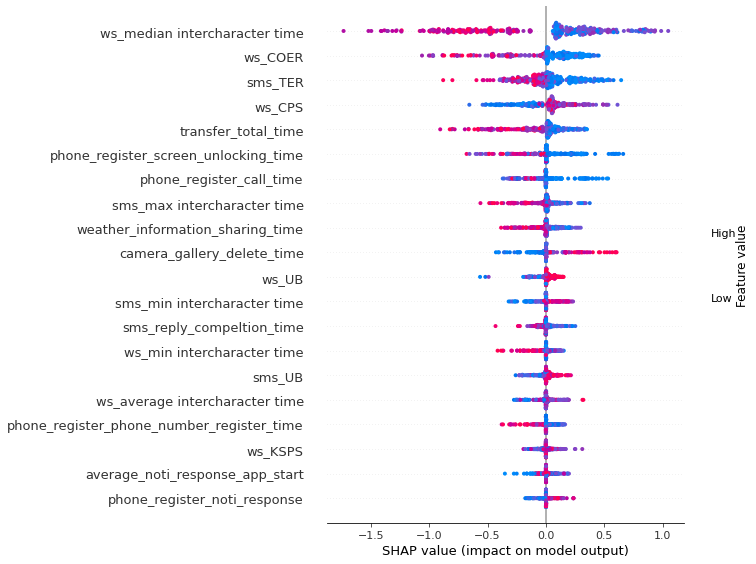

In [28]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[1], X_test, show=False)
    plt.savefig('shap_summaryplot_lgbm_3label_class2.png', bbox_inches='tight')

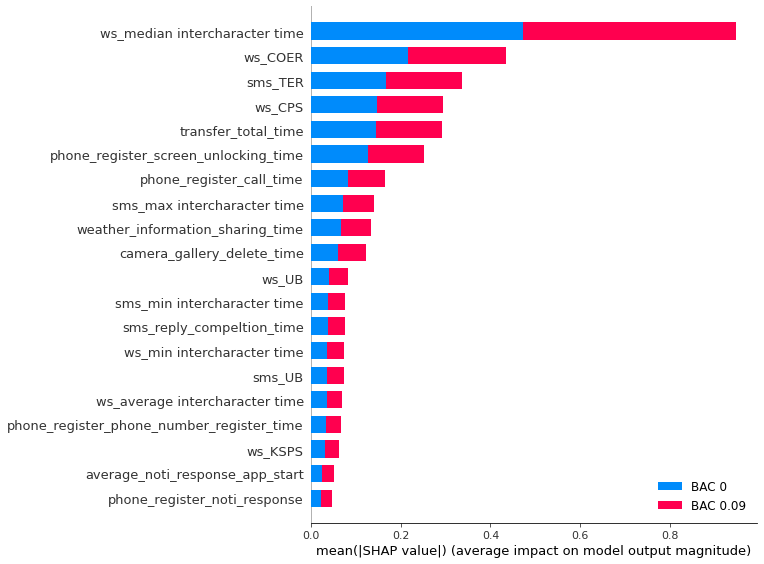

In [30]:
if label_name == 'three_label':
    shap_values = [shap_values[0], shap_values[1], shap_values[2]]
    shap.summary_plot(shap_values, X_test, class_names=['BAL 0', 'BAL 0.03-0.06', 'BAL 0.06-0.09'], class_inds=[0, 1, 2])
    plt.savefig('shap_absmeanplot_lgbm_3label.png', bbox_inches='tight')

# Xgboost Bayesian

In [31]:
class XBGObjective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial: Trial):    
        xgb_params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0, step=0.1),
            'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 5.0), # lambda_l1
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0), # lambda_l2
            'random_state': 42
        }

        clf = XGBClassifier(**xgb_params)

        mean_accuracy = InnerCrossValidation(clf, self.X, self.y, cv_method, n_fold)

        return mean_accuracy

In [32]:
clf = XGBClassifier(random_state=42)
shap_values, X_test, metric_df = NestedCVwithOptuna(XBGObjective, clf, 'xgboost')

[I 2022-08-28 22:22:07,306] A new study created in memory with name: xgboost Study


class_nums :  2


[I 2022-08-28 22:22:10,122] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 439, 'learning_rate': 0.0002472873616023207, 'max_depth': 8, 'min_child_weight': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'gamma': 0.2, 'reg_alpha': 1.779755163462574, 'reg_lambda': 1.8620792710380027}. Best is trial 0 with value: 0.7692307692307693.


Optuna Best score :  0.7692307692307693


[I 2022-08-28 22:22:10,569] A new study created in memory with name: xgboost Study


test accuracy :  1.0


[I 2022-08-28 22:22:12,646] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 415, 'learning_rate': 0.007132260495815669, 'max_depth': 4, 'min_child_weight': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'gamma': 4.1000000000000005, 'reg_alpha': 4.150335636616924, 'reg_lambda': 3.0634693174330714}. Best is trial 0 with value: 0.7692307692307693.


Optuna Best score :  0.7692307692307693


[I 2022-08-28 22:22:12,966] A new study created in memory with name: xgboost Study


test accuracy :  1.0


[I 2022-08-28 22:22:15,356] Trial 0 finished with value: 0.7435897435897436 and parameters: {'n_estimators': 417, 'learning_rate': 0.0002570443509561165, 'max_depth': 7, 'min_child_weight': 4, 'colsample_bytree': 0.6, 'subsample': 0.9, 'gamma': 0.7000000000000001, 'reg_alpha': 4.94986912699046, 'reg_lambda': 4.991730690571341}. Best is trial 0 with value: 0.7435897435897436.


Optuna Best score :  0.7435897435897436


[I 2022-08-28 22:22:15,700] A new study created in memory with name: xgboost Study


test accuracy :  1.0


[I 2022-08-28 22:22:17,148] Trial 0 finished with value: 0.7492877492877493 and parameters: {'n_estimators': 346, 'learning_rate': 0.0001573611932151284, 'max_depth': 3, 'min_child_weight': 7, 'colsample_bytree': 0.5, 'subsample': 0.7, 'gamma': 2.8000000000000003, 'reg_alpha': 3.283777247927489, 'reg_lambda': 1.572738845633281}. Best is trial 0 with value: 0.7492877492877493.


Optuna Best score :  0.7492877492877493
test accuracy :  1.0


[I 2022-08-28 22:22:17,355] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:22:18,380] Trial 0 finished with value: 0.792022792022792 and parameters: {'n_estimators': 168, 'learning_rate': 0.025089503356483633, 'max_depth': 6, 'min_child_weight': 2, 'colsample_bytree': 0.9, 'subsample': 0.8, 'gamma': 3.0, 'reg_alpha': 1.5952222536120066, 'reg_lambda': 4.283981902958346}. Best is trial 0 with value: 0.792022792022792.


Optuna Best score :  0.792022792022792
test accuracy :  1.0


[I 2022-08-28 22:22:18,590] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:22:19,565] Trial 0 finished with value: 0.7321937321937322 and parameters: {'n_estimators': 244, 'learning_rate': 0.0007769840413821829, 'max_depth': 7, 'min_child_weight': 9, 'colsample_bytree': 0.6, 'subsample': 0.7, 'gamma': 0.7000000000000001, 'reg_alpha': 3.356698722631553, 'reg_lambda': 1.0990767541893942}. Best is trial 0 with value: 0.7321937321937322.
[I 2022-08-28 22:22:19,719] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7321937321937322
test accuracy :  1.0


[I 2022-08-28 22:22:20,928] Trial 0 finished with value: 0.7663817663817664 and parameters: {'n_estimators': 307, 'learning_rate': 0.09095157633421118, 'max_depth': 3, 'min_child_weight': 1, 'colsample_bytree': 0.9, 'subsample': 0.8, 'gamma': 0.6000000000000001, 'reg_alpha': 4.350634051157123, 'reg_lambda': 1.760735260969088}. Best is trial 0 with value: 0.7663817663817664.
[I 2022-08-28 22:22:21,127] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7663817663817664
test accuracy :  1.0


[I 2022-08-28 22:22:22,308] Trial 0 finished with value: 0.7549857549857549 and parameters: {'n_estimators': 246, 'learning_rate': 0.00024992198130392463, 'max_depth': 4, 'min_child_weight': 8, 'colsample_bytree': 0.8, 'subsample': 1.0, 'gamma': 0.30000000000000004, 'reg_alpha': 2.051589433203005, 'reg_lambda': 3.0637623989450273}. Best is trial 0 with value: 0.7549857549857549.
[I 2022-08-28 22:22:22,488] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7549857549857549
test accuracy :  1.0


[I 2022-08-28 22:22:24,181] Trial 0 finished with value: 0.7207977207977208 and parameters: {'n_estimators': 447, 'learning_rate': 0.0008726794771117431, 'max_depth': 9, 'min_child_weight': 9, 'colsample_bytree': 0.7, 'subsample': 0.5, 'gamma': 4.2, 'reg_alpha': 1.915290709386512, 'reg_lambda': 2.4510578273217}. Best is trial 0 with value: 0.7207977207977208.


Optuna Best score :  0.7207977207977208
test accuracy :  1.0


[I 2022-08-28 22:22:24,411] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:22:26,016] Trial 0 finished with value: 0.7521367521367521 and parameters: {'n_estimators': 394, 'learning_rate': 0.00161859702010901, 'max_depth': 7, 'min_child_weight': 7, 'colsample_bytree': 1.0, 'subsample': 0.6, 'gamma': 0.7000000000000001, 'reg_alpha': 4.367850190240267, 'reg_lambda': 2.0140485069666036}. Best is trial 0 with value: 0.7521367521367521.


Optuna Best score :  0.7521367521367521
test accuracy :  0.8888888888888888


[I 2022-08-28 22:22:26,238] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:22:27,233] Trial 0 finished with value: 0.7606837606837606 and parameters: {'n_estimators': 209, 'learning_rate': 0.0008953223623360992, 'max_depth': 8, 'min_child_weight': 3, 'colsample_bytree': 1.0, 'subsample': 0.6, 'gamma': 1.8, 'reg_alpha': 2.280002930115382, 'reg_lambda': 4.044638042927836}. Best is trial 0 with value: 0.7606837606837606.
[I 2022-08-28 22:22:27,397] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7606837606837606
test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:28,146] Trial 0 finished with value: 0.7635327635327636 and parameters: {'n_estimators': 166, 'learning_rate': 0.00040130162236227566, 'max_depth': 7, 'min_child_weight': 8, 'colsample_bytree': 0.6, 'subsample': 0.7, 'gamma': 0.2, 'reg_alpha': 1.8819207012063157, 'reg_lambda': 2.3677426958828907}. Best is trial 0 with value: 0.7635327635327636.
[I 2022-08-28 22:22:28,249] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7635327635327636
test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:31,018] Trial 0 finished with value: 0.811965811965812 and parameters: {'n_estimators': 444, 'learning_rate': 0.004378699808908474, 'max_depth': 10, 'min_child_weight': 2, 'colsample_bytree': 0.7, 'subsample': 1.0, 'gamma': 0.6000000000000001, 'reg_alpha': 3.3145528850981107, 'reg_lambda': 1.9343786183710492}. Best is trial 0 with value: 0.811965811965812.


Optuna Best score :  0.811965811965812


[I 2022-08-28 22:22:31,512] A new study created in memory with name: xgboost Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:32,650] Trial 0 finished with value: 0.7207977207977208 and parameters: {'n_estimators': 341, 'learning_rate': 0.00016339633720776007, 'max_depth': 9, 'min_child_weight': 9, 'colsample_bytree': 0.8, 'subsample': 0.5, 'gamma': 4.9, 'reg_alpha': 1.7994311580937428, 'reg_lambda': 4.995017967395645}. Best is trial 0 with value: 0.7207977207977208.


Optuna Best score :  0.7207977207977208
test accuracy :  0.7777777777777778


[I 2022-08-28 22:22:32,853] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:22:34,484] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 391, 'learning_rate': 0.00016026547273547122, 'max_depth': 4, 'min_child_weight': 7, 'colsample_bytree': 1.0, 'subsample': 0.8, 'gamma': 3.2, 'reg_alpha': 1.761623104921235, 'reg_lambda': 3.7139157764696806}. Best is trial 0 with value: 0.7692307692307693.


Optuna Best score :  0.7692307692307693


[I 2022-08-28 22:22:34,740] A new study created in memory with name: xgboost Study


test accuracy :  0.8888888888888888


[I 2022-08-28 22:22:35,588] Trial 0 finished with value: 0.8034188034188035 and parameters: {'n_estimators': 112, 'learning_rate': 0.01710329921442241, 'max_depth': 7, 'min_child_weight': 1, 'colsample_bytree': 1.0, 'subsample': 0.7, 'gamma': 0.7000000000000001, 'reg_alpha': 3.393052380189377, 'reg_lambda': 3.547883247208093}. Best is trial 0 with value: 0.8034188034188035.
[I 2022-08-28 22:22:35,720] A new study created in memory with name: xgboost Study


Optuna Best score :  0.8034188034188035
test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:36,017] Trial 0 finished with value: 0.792022792022792 and parameters: {'n_estimators': 53, 'learning_rate': 0.033172906398642045, 'max_depth': 9, 'min_child_weight': 9, 'colsample_bytree': 1.0, 'subsample': 1.0, 'gamma': 4.0, 'reg_alpha': 1.5614012217235347, 'reg_lambda': 1.9987292840603494}. Best is trial 0 with value: 0.792022792022792.
[I 2022-08-28 22:22:36,066] A new study created in memory with name: xgboost Study


Optuna Best score :  0.792022792022792
test accuracy :  0.5555555555555556


[I 2022-08-28 22:22:36,496] Trial 0 finished with value: 0.8034188034188035 and parameters: {'n_estimators': 73, 'learning_rate': 0.03227378099468157, 'max_depth': 6, 'min_child_weight': 3, 'colsample_bytree': 0.8, 'subsample': 0.8, 'gamma': 0.7000000000000001, 'reg_alpha': 3.3129076697197464, 'reg_lambda': 2.2597201480697566}. Best is trial 0 with value: 0.8034188034188035.
[I 2022-08-28 22:22:36,572] A new study created in memory with name: xgboost Study


Optuna Best score :  0.8034188034188035
test accuracy :  0.5555555555555556


[I 2022-08-28 22:22:37,735] Trial 0 finished with value: 0.7635327635327636 and parameters: {'n_estimators': 302, 'learning_rate': 0.004119735069549154, 'max_depth': 7, 'min_child_weight': 9, 'colsample_bytree': 1.0, 'subsample': 0.8, 'gamma': 3.1, 'reg_alpha': 4.663193467446092, 'reg_lambda': 2.73695559996948}. Best is trial 0 with value: 0.7635327635327636.


Optuna Best score :  0.7635327635327636
test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:37,956] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:22:38,622] Trial 0 finished with value: 0.8091168091168092 and parameters: {'n_estimators': 116, 'learning_rate': 0.05626625117181885, 'max_depth': 6, 'min_child_weight': 3, 'colsample_bytree': 0.9, 'subsample': 0.8, 'gamma': 1.4000000000000001, 'reg_alpha': 4.173592042364968, 'reg_lambda': 4.163138993672922}. Best is trial 0 with value: 0.8091168091168092.
[I 2022-08-28 22:22:38,737] A new study created in memory with name: xgboost Study


Optuna Best score :  0.8091168091168092
test accuracy :  0.8888888888888888


[I 2022-08-28 22:22:41,146] Trial 0 finished with value: 0.7977207977207977 and parameters: {'n_estimators': 421, 'learning_rate': 0.006143330167985399, 'max_depth': 5, 'min_child_weight': 1, 'colsample_bytree': 0.7, 'subsample': 0.7, 'gamma': 0.9, 'reg_alpha': 2.3253818557510124, 'reg_lambda': 4.891949713723024}. Best is trial 0 with value: 0.7977207977207977.


Optuna Best score :  0.7977207977207977


[I 2022-08-28 22:22:41,547] A new study created in memory with name: xgboost Study


test accuracy :  0.8888888888888888


[I 2022-08-28 22:22:42,031] Trial 0 finished with value: 0.7606837606837606 and parameters: {'n_estimators': 71, 'learning_rate': 0.01116865379534018, 'max_depth': 9, 'min_child_weight': 4, 'colsample_bytree': 0.9, 'subsample': 1.0, 'gamma': 2.5, 'reg_alpha': 1.0548660234217122, 'reg_lambda': 4.277259114861744}. Best is trial 0 with value: 0.7606837606837606.
[I 2022-08-28 22:22:42,105] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7606837606837606
test accuracy :  0.5555555555555556


[I 2022-08-28 22:22:43,126] Trial 0 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 241, 'learning_rate': 0.007499792891369625, 'max_depth': 6, 'min_child_weight': 9, 'colsample_bytree': 1.0, 'subsample': 1.0, 'gamma': 0.4, 'reg_alpha': 3.0076557128557417, 'reg_lambda': 1.8582469201558158}. Best is trial 0 with value: 0.7777777777777778.
[I 2022-08-28 22:22:43,293] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7777777777777778
test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:43,958] Trial 0 finished with value: 0.7521367521367521 and parameters: {'n_estimators': 154, 'learning_rate': 0.0006847696586085113, 'max_depth': 8, 'min_child_weight': 8, 'colsample_bytree': 0.8, 'subsample': 0.9, 'gamma': 0.2, 'reg_alpha': 3.349715160290812, 'reg_lambda': 4.940499441870771}. Best is trial 0 with value: 0.7521367521367521.
[I 2022-08-28 22:22:44,067] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7521367521367521
test accuracy :  0.7777777777777778


[I 2022-08-28 22:22:44,699] Trial 0 finished with value: 0.7806267806267806 and parameters: {'n_estimators': 133, 'learning_rate': 0.012598290593487547, 'max_depth': 4, 'min_child_weight': 3, 'colsample_bytree': 0.8, 'subsample': 0.6, 'gamma': 0.30000000000000004, 'reg_alpha': 3.2355134603118816, 'reg_lambda': 3.7431853866748828}. Best is trial 0 with value: 0.7806267806267806.
[I 2022-08-28 22:22:44,803] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7806267806267806
test accuracy :  0.5555555555555556


[I 2022-08-28 22:22:46,080] Trial 0 finished with value: 0.7720797720797721 and parameters: {'n_estimators': 275, 'learning_rate': 0.010286677422048212, 'max_depth': 9, 'min_child_weight': 8, 'colsample_bytree': 1.0, 'subsample': 1.0, 'gamma': 2.8000000000000003, 'reg_alpha': 3.700403454423865, 'reg_lambda': 4.564813216709039}. Best is trial 0 with value: 0.7720797720797721.


Optuna Best score :  0.7720797720797721


[I 2022-08-28 22:22:46,350] A new study created in memory with name: xgboost Study


test accuracy :  0.7777777777777778


[I 2022-08-28 22:22:47,890] Trial 0 finished with value: 0.7606837606837606 and parameters: {'n_estimators': 469, 'learning_rate': 0.0002540971537179174, 'max_depth': 8, 'min_child_weight': 8, 'colsample_bytree': 1.0, 'subsample': 0.5, 'gamma': 0.0, 'reg_alpha': 3.963776706566543, 'reg_lambda': 1.8202682753781558}. Best is trial 0 with value: 0.7606837606837606.


Optuna Best score :  0.7606837606837606
test accuracy :  0.4444444444444444


[I 2022-08-28 22:22:48,122] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:22:49,750] Trial 0 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 410, 'learning_rate': 0.025120095667334915, 'max_depth': 3, 'min_child_weight': 5, 'colsample_bytree': 0.5, 'subsample': 0.5, 'gamma': 1.4000000000000001, 'reg_alpha': 4.717131717540265, 'reg_lambda': 3.115180967165032}. Best is trial 0 with value: 0.7948717948717948.


Optuna Best score :  0.7948717948717948


[I 2022-08-28 22:22:49,994] A new study created in memory with name: xgboost Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:51,119] Trial 0 finished with value: 0.7891737891737892 and parameters: {'n_estimators': 322, 'learning_rate': 0.026264286023403954, 'max_depth': 8, 'min_child_weight': 7, 'colsample_bytree': 0.8, 'subsample': 0.6, 'gamma': 3.0, 'reg_alpha': 3.474122818221138, 'reg_lambda': 4.574992509269601}. Best is trial 0 with value: 0.7891737891737892.
[I 2022-08-28 22:22:51,291] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7891737891737892
test accuracy :  0.5555555555555556


[I 2022-08-28 22:22:52,419] Trial 0 finished with value: 0.7578347578347578 and parameters: {'n_estimators': 312, 'learning_rate': 0.08674427249976438, 'max_depth': 4, 'min_child_weight': 8, 'colsample_bytree': 0.5, 'subsample': 0.8, 'gamma': 0.0, 'reg_alpha': 2.4573375535396864, 'reg_lambda': 2.031313436920013}. Best is trial 0 with value: 0.7578347578347578.


Optuna Best score :  0.7578347578347578
test accuracy :  0.7777777777777778


[I 2022-08-28 22:22:52,629] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:22:53,572] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 249, 'learning_rate': 0.005595832742110544, 'max_depth': 5, 'min_child_weight': 5, 'colsample_bytree': 0.7, 'subsample': 0.6, 'gamma': 2.2, 'reg_alpha': 4.058887170320906, 'reg_lambda': 1.4265711221073665}. Best is trial 0 with value: 0.7692307692307693.
[I 2022-08-28 22:22:53,739] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7692307692307693
test accuracy :  0.8888888888888888


[I 2022-08-28 22:22:54,073] Trial 0 finished with value: 0.7578347578347578 and parameters: {'n_estimators': 57, 'learning_rate': 0.01311677735207692, 'max_depth': 5, 'min_child_weight': 6, 'colsample_bytree': 1.0, 'subsample': 1.0, 'gamma': 3.0, 'reg_alpha': 2.531556435648844, 'reg_lambda': 2.6928701380125526}. Best is trial 0 with value: 0.7578347578347578.
[I 2022-08-28 22:22:54,129] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7578347578347578
test accuracy :  0.7777777777777778


[I 2022-08-28 22:22:55,531] Trial 0 finished with value: 0.7663817663817664 and parameters: {'n_estimators': 275, 'learning_rate': 0.0056555042071181946, 'max_depth': 4, 'min_child_weight': 6, 'colsample_bytree': 1.0, 'subsample': 1.0, 'gamma': 1.3, 'reg_alpha': 1.9434198942670333, 'reg_lambda': 2.627413084505556}. Best is trial 0 with value: 0.7663817663817664.


Optuna Best score :  0.7663817663817664


[I 2022-08-28 22:22:55,794] A new study created in memory with name: xgboost Study


test accuracy :  0.8888888888888888


[I 2022-08-28 22:22:56,782] Trial 0 finished with value: 0.7606837606837606 and parameters: {'n_estimators': 173, 'learning_rate': 0.00083792098475635, 'max_depth': 8, 'min_child_weight': 3, 'colsample_bytree': 1.0, 'subsample': 0.8, 'gamma': 1.1, 'reg_alpha': 3.189021299073327, 'reg_lambda': 2.6220180154201724}. Best is trial 0 with value: 0.7606837606837606.
[I 2022-08-28 22:22:56,942] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7606837606837606
test accuracy :  0.6666666666666666


[I 2022-08-28 22:22:57,520] Trial 0 finished with value: 0.7663817663817664 and parameters: {'n_estimators': 122, 'learning_rate': 0.00019814885725945368, 'max_depth': 7, 'min_child_weight': 6, 'colsample_bytree': 1.0, 'subsample': 0.8, 'gamma': 2.1, 'reg_alpha': 3.400968164684875, 'reg_lambda': 2.4733384171881783}. Best is trial 0 with value: 0.7663817663817664.
[I 2022-08-28 22:22:57,619] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7663817663817664
test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:00,089] Trial 0 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 491, 'learning_rate': 0.04004540663984456, 'max_depth': 9, 'min_child_weight': 3, 'colsample_bytree': 0.6, 'subsample': 0.9, 'gamma': 2.7, 'reg_alpha': 4.814720255674183, 'reg_lambda': 3.3191595949105195}. Best is trial 0 with value: 0.7777777777777778.


Optuna Best score :  0.7777777777777778


[I 2022-08-28 22:23:00,544] A new study created in memory with name: xgboost Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:01,999] Trial 0 finished with value: 0.7521367521367521 and parameters: {'n_estimators': 225, 'learning_rate': 0.0001903455723320209, 'max_depth': 7, 'min_child_weight': 3, 'colsample_bytree': 1.0, 'subsample': 1.0, 'gamma': 1.9000000000000001, 'reg_alpha': 2.125473877961378, 'reg_lambda': 3.4492998418119205}. Best is trial 0 with value: 0.7521367521367521.


Optuna Best score :  0.7521367521367521
test accuracy :  0.3333333333333333


[I 2022-08-28 22:23:02,247] A new study created in memory with name: xgboost Study
[I 2022-08-28 22:23:03,970] Trial 0 finished with value: 0.7549857549857549 and parameters: {'n_estimators': 449, 'learning_rate': 0.00024268954115243773, 'max_depth': 3, 'min_child_weight': 6, 'colsample_bytree': 0.6, 'subsample': 0.9, 'gamma': 0.4, 'reg_alpha': 3.577671621935351, 'reg_lambda': 4.511967861123894}. Best is trial 0 with value: 0.7549857549857549.


Optuna Best score :  0.7549857549857549


[I 2022-08-28 22:23:04,237] A new study created in memory with name: xgboost Study


test accuracy :  0.5555555555555556


[I 2022-08-28 22:23:04,572] Trial 0 finished with value: 0.7264957264957265 and parameters: {'n_estimators': 73, 'learning_rate': 0.00016832020808169008, 'max_depth': 7, 'min_child_weight': 8, 'colsample_bytree': 1.0, 'subsample': 0.5, 'gamma': 3.6, 'reg_alpha': 3.38313210881419, 'reg_lambda': 4.817883719821394}. Best is trial 0 with value: 0.7264957264957265.
[I 2022-08-28 22:23:04,622] A new study created in memory with name: xgboost Study


Optuna Best score :  0.7264957264957265
test accuracy :  0.7777777777777778


[I 2022-08-28 22:23:05,379] Trial 0 finished with value: 0.7350427350427351 and parameters: {'n_estimators': 231, 'learning_rate': 0.0002492853177412892, 'max_depth': 9, 'min_child_weight': 8, 'colsample_bytree': 0.6, 'subsample': 0.6, 'gamma': 4.800000000000001, 'reg_alpha': 4.293663243831675, 'reg_lambda': 1.9381776651413425}. Best is trial 0 with value: 0.7350427350427351.


Optuna Best score :  0.7350427350427351
test accuracy :  0.6666666666666666

mean accuracy :  0.7611111111111113
mean precision :  0.7611111111111113
mean recall :  0.7020833333333334
mean f1 :  0.6698419635919639
mean roc_auc :  0.7020833333333334



## 40개의 모델의 개별 performance metric + 평균 performnace metric을 저장한다
## 각 모델별 test set의 feature에 따른 shap value를 저장한다

In [33]:
if label_name == 'three_label':
    shap_values_df_0 = pd.DataFrame(shap_values[0], columns=X_test.columns)
    shap_values_df_1 = pd.DataFrame(shap_values[1], columns=X_test.columns)
    shap_values_df_2 = pd.DataFrame(shap_values[2], columns=X_test.columns)

    with pd.ExcelWriter(f"./xgb_result_3_label.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
        shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
        shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label':
    shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)

    with pd.ExcelWriter(f"./xgb_result_3_label.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

## 3 Labels

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[0], X_test, show=False)
    plt.savefig('shap_summaryplot_xgb_3label_class0.png', bbox_inches='tight')

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[1], X_test, show=False)
    plt.savefig('shap_summaryplot_xgb_3label_class1.png', bbox_inches='tight')

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[2], X_test, show=False)
    plt.savefig('shap_summaryplot_xgb_3label_class2.png', bbox_inches='tight')

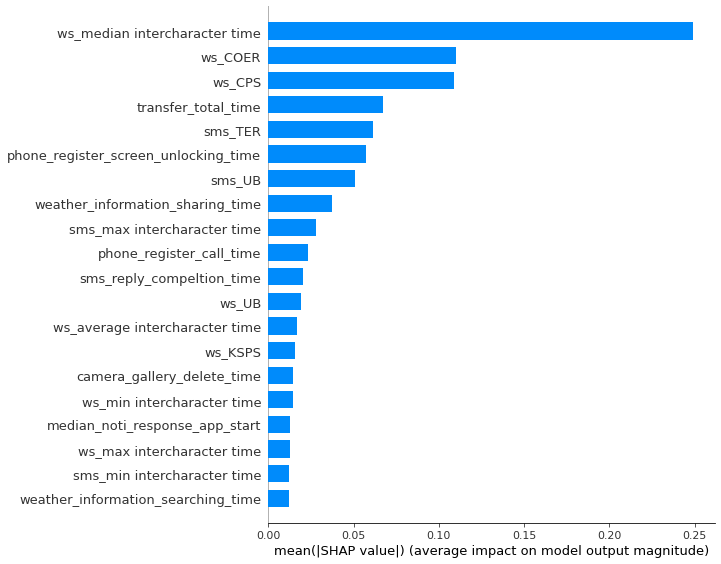

In [39]:
if label_name == 'three_label':
    shap_values = [shap_values[0], shap_values[1], shap_values[2]]
    shap.summary_plot(shap_values, X_test, class_names=['BAL 0', 'BAL 0.03-0.06', 'BAL 0.06-0.09'], class_inds=[0, 1, 2])
    plt.savefig('shap_absmeanplot_xgb_3label.png', bbox_inches='tight')

# Random Forest Bayesian

In [40]:
class RFObjective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __call__(self, trial: Trial):
        rf_params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'random_state': 42
        }

        clf = RandomForestClassifier(**rf_params)

        mean_accuracy = InnerCrossValidation(clf, self.X, self.y, cv_method, n_fold)

        return mean_accuracy

In [41]:
clf = RandomForestClassifier(random_state=42)
shap_values, X_test, metric_df = NestedCVwithOptuna(RFObjective, clf, 'randomforest')

[I 2022-08-28 22:23:06,299] A new study created in memory with name: randomforest Study


class_nums :  2


[I 2022-08-28 22:23:07,191] Trial 0 finished with value: 0.7806267806267806 and parameters: {'n_estimators': 134, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 4}. Best is trial 0 with value: 0.7806267806267806.
[I 2022-08-28 22:23:07,303] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7806267806267806
test accuracy :  1.0


[I 2022-08-28 22:23:07,972] Trial 0 finished with value: 0.8005698005698005 and parameters: {'n_estimators': 101, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 5}. Best is trial 0 with value: 0.8005698005698005.
[I 2022-08-28 22:23:08,057] A new study created in memory with name: randomforest Study


Optuna Best score :  0.8005698005698005
test accuracy :  1.0


[I 2022-08-28 22:23:10,049] Trial 0 finished with value: 0.7891737891737892 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5}. Best is trial 0 with value: 0.7891737891737892.


Optuna Best score :  0.7891737891737892
test accuracy :  1.0


[I 2022-08-28 22:23:10,294] A new study created in memory with name: randomforest Study
[I 2022-08-28 22:23:11,360] Trial 0 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 170, 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 10}. Best is trial 0 with value: 0.7692307692307693.
[I 2022-08-28 22:23:11,497] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7692307692307693
test accuracy :  1.0


[I 2022-08-28 22:23:14,054] Trial 0 finished with value: 0.7834757834757835 and parameters: {'n_estimators': 424, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 0 with value: 0.7834757834757835.


Optuna Best score :  0.7834757834757835


[I 2022-08-28 22:23:14,363] A new study created in memory with name: randomforest Study


test accuracy :  1.0


[I 2022-08-28 22:23:15,162] Trial 0 finished with value: 0.792022792022792 and parameters: {'n_estimators': 117, 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}. Best is trial 0 with value: 0.792022792022792.
[I 2022-08-28 22:23:15,263] A new study created in memory with name: randomforest Study


Optuna Best score :  0.792022792022792
test accuracy :  1.0


[I 2022-08-28 22:23:16,308] Trial 0 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 170, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5}. Best is trial 0 with value: 0.7777777777777778.
[I 2022-08-28 22:23:16,435] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7777777777777778
test accuracy :  1.0


[I 2022-08-28 22:23:18,153] Trial 0 finished with value: 0.7977207977207977 and parameters: {'n_estimators': 257, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 8}. Best is trial 0 with value: 0.7977207977207977.


Optuna Best score :  0.7977207977207977


[I 2022-08-28 22:23:18,382] A new study created in memory with name: randomforest Study


test accuracy :  1.0


[I 2022-08-28 22:23:20,149] Trial 0 finished with value: 0.7891737891737892 and parameters: {'n_estimators': 261, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.7891737891737892.


Optuna Best score :  0.7891737891737892


[I 2022-08-28 22:23:20,374] A new study created in memory with name: randomforest Study


test accuracy :  1.0


[I 2022-08-28 22:23:21,287] Trial 0 finished with value: 0.8062678062678063 and parameters: {'n_estimators': 132, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}. Best is trial 0 with value: 0.8062678062678063.
[I 2022-08-28 22:23:21,400] A new study created in memory with name: randomforest Study


Optuna Best score :  0.8062678062678063
test accuracy :  0.8888888888888888


[I 2022-08-28 22:23:21,832] Trial 0 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 60, 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 5}. Best is trial 0 with value: 0.7948717948717948.
[I 2022-08-28 22:23:21,888] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7948717948717948
test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:22,893] Trial 0 finished with value: 0.7863247863247863 and parameters: {'n_estimators': 158, 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 6}. Best is trial 0 with value: 0.7863247863247863.
[I 2022-08-28 22:23:23,018] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7863247863247863
test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:25,341] Trial 0 finished with value: 0.8034188034188035 and parameters: {'n_estimators': 379, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 8}. Best is trial 0 with value: 0.8034188034188035.


Optuna Best score :  0.8034188034188035


[I 2022-08-28 22:23:25,620] A new study created in memory with name: randomforest Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:28,465] Trial 0 finished with value: 0.7891737891737892 and parameters: {'n_estimators': 443, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 2}. Best is trial 0 with value: 0.7891737891737892.


Optuna Best score :  0.7891737891737892


[I 2022-08-28 22:23:28,818] A new study created in memory with name: randomforest Study


test accuracy :  0.7777777777777778


[I 2022-08-28 22:23:31,832] Trial 0 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 493, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 0 with value: 0.7948717948717948.


Optuna Best score :  0.7948717948717948


[I 2022-08-28 22:23:32,196] A new study created in memory with name: randomforest Study


test accuracy :  0.7777777777777778


[I 2022-08-28 22:23:34,047] Trial 0 finished with value: 0.7863247863247863 and parameters: {'n_estimators': 329, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}. Best is trial 0 with value: 0.7863247863247863.
[I 2022-08-28 22:23:34,270] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7863247863247863
test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:36,160] Trial 0 finished with value: 0.7977207977207977 and parameters: {'n_estimators': 305, 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 6}. Best is trial 0 with value: 0.7977207977207977.
[I 2022-08-28 22:23:36,394] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7977207977207977
test accuracy :  0.5555555555555556


[I 2022-08-28 22:23:38,046] Trial 0 finished with value: 0.8034188034188035 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 4}. Best is trial 0 with value: 0.8034188034188035.
[I 2022-08-28 22:23:38,255] A new study created in memory with name: randomforest Study


Optuna Best score :  0.8034188034188035
test accuracy :  0.7777777777777778


[I 2022-08-28 22:23:41,019] Trial 0 finished with value: 0.7863247863247863 and parameters: {'n_estimators': 435, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 3}. Best is trial 0 with value: 0.7863247863247863.


Optuna Best score :  0.7863247863247863


[I 2022-08-28 22:23:41,373] A new study created in memory with name: randomforest Study


test accuracy :  1.0


[I 2022-08-28 22:23:44,111] Trial 0 finished with value: 0.7806267806267806 and parameters: {'n_estimators': 484, 'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 9}. Best is trial 0 with value: 0.7806267806267806.


Optuna Best score :  0.7806267806267806


[I 2022-08-28 22:23:44,435] A new study created in memory with name: randomforest Study


test accuracy :  0.8888888888888888


[I 2022-08-28 22:23:46,961] Trial 0 finished with value: 0.8005698005698005 and parameters: {'n_estimators': 380, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 7}. Best is trial 0 with value: 0.8005698005698005.


Optuna Best score :  0.8005698005698005


[I 2022-08-28 22:23:47,280] A new study created in memory with name: randomforest Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:49,658] Trial 0 finished with value: 0.7891737891737892 and parameters: {'n_estimators': 371, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}. Best is trial 0 with value: 0.7891737891737892.


Optuna Best score :  0.7891737891737892


[I 2022-08-28 22:23:50,015] A new study created in memory with name: randomforest Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:52,067] Trial 0 finished with value: 0.7977207977207977 and parameters: {'n_estimators': 333, 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 4}. Best is trial 0 with value: 0.7977207977207977.


Optuna Best score :  0.7977207977207977


[I 2022-08-28 22:23:52,320] A new study created in memory with name: randomforest Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:23:53,675] Trial 0 finished with value: 0.7863247863247863 and parameters: {'n_estimators': 222, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 7}. Best is trial 0 with value: 0.7863247863247863.
[I 2022-08-28 22:23:53,839] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7863247863247863
test accuracy :  0.7777777777777778


[I 2022-08-28 22:23:55,525] Trial 0 finished with value: 0.8062678062678063 and parameters: {'n_estimators': 240, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4}. Best is trial 0 with value: 0.8062678062678063.
[I 2022-08-28 22:23:55,738] A new study created in memory with name: randomforest Study


Optuna Best score :  0.8062678062678063
test accuracy :  0.5555555555555556


[I 2022-08-28 22:23:57,317] Trial 0 finished with value: 0.8034188034188035 and parameters: {'n_estimators': 243, 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 7}. Best is trial 0 with value: 0.8034188034188035.
[I 2022-08-28 22:23:57,523] A new study created in memory with name: randomforest Study


Optuna Best score :  0.8034188034188035
test accuracy :  0.8888888888888888


[I 2022-08-28 22:23:58,911] Trial 0 finished with value: 0.792022792022792 and parameters: {'n_estimators': 214, 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 3}. Best is trial 0 with value: 0.792022792022792.
[I 2022-08-28 22:23:59,089] A new study created in memory with name: randomforest Study


Optuna Best score :  0.792022792022792
test accuracy :  0.8888888888888888


[I 2022-08-28 22:23:59,983] Trial 0 finished with value: 0.7977207977207977 and parameters: {'n_estimators': 147, 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 7}. Best is trial 0 with value: 0.7977207977207977.
[I 2022-08-28 22:24:00,093] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7977207977207977
test accuracy :  0.5555555555555556


[I 2022-08-28 22:24:01,174] Trial 0 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 3}. Best is trial 0 with value: 0.7948717948717948.
[I 2022-08-28 22:24:01,311] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7948717948717948
test accuracy :  0.5555555555555556


[I 2022-08-28 22:24:02,110] Trial 0 finished with value: 0.792022792022792 and parameters: {'n_estimators': 134, 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 9}. Best is trial 0 with value: 0.792022792022792.
[I 2022-08-28 22:24:02,215] A new study created in memory with name: randomforest Study


Optuna Best score :  0.792022792022792
test accuracy :  0.7777777777777778


[I 2022-08-28 22:24:05,466] Trial 0 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 469, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 0 with value: 0.7948717948717948.


Optuna Best score :  0.7948717948717948


[I 2022-08-28 22:24:05,886] A new study created in memory with name: randomforest Study


test accuracy :  0.8888888888888888


[I 2022-08-28 22:24:08,589] Trial 0 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 415, 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 4}. Best is trial 0 with value: 0.7948717948717948.


Optuna Best score :  0.7948717948717948


[I 2022-08-28 22:24:08,927] A new study created in memory with name: randomforest Study


test accuracy :  0.7777777777777778


[I 2022-08-28 22:24:09,614] Trial 0 finished with value: 0.8034188034188035 and parameters: {'n_estimators': 104, 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 2}. Best is trial 0 with value: 0.8034188034188035.
[I 2022-08-28 22:24:09,705] A new study created in memory with name: randomforest Study


Optuna Best score :  0.8034188034188035
test accuracy :  0.6666666666666666


[I 2022-08-28 22:24:12,729] Trial 0 finished with value: 0.792022792022792 and parameters: {'n_estimators': 492, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}. Best is trial 0 with value: 0.792022792022792.


Optuna Best score :  0.792022792022792


[I 2022-08-28 22:24:13,095] A new study created in memory with name: randomforest Study


test accuracy :  0.8888888888888888


[I 2022-08-28 22:24:15,818] Trial 0 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 489, 'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 10}. Best is trial 0 with value: 0.7777777777777778.


Optuna Best score :  0.7777777777777778


[I 2022-08-28 22:24:16,157] A new study created in memory with name: randomforest Study


test accuracy :  0.7777777777777778


[I 2022-08-28 22:24:19,116] Trial 0 finished with value: 0.7806267806267806 and parameters: {'n_estimators': 472, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8}. Best is trial 0 with value: 0.7806267806267806.


Optuna Best score :  0.7806267806267806


[I 2022-08-28 22:24:19,484] A new study created in memory with name: randomforest Study


test accuracy :  0.6666666666666666


[I 2022-08-28 22:24:20,665] Trial 0 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 185, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}. Best is trial 0 with value: 0.7948717948717948.
[I 2022-08-28 22:24:20,814] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7948717948717948
test accuracy :  0.3333333333333333


[I 2022-08-28 22:24:21,340] Trial 0 finished with value: 0.7863247863247863 and parameters: {'n_estimators': 81, 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 8}. Best is trial 0 with value: 0.7863247863247863.
[I 2022-08-28 22:24:21,409] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7863247863247863
test accuracy :  0.7777777777777778


[I 2022-08-28 22:24:21,816] Trial 0 finished with value: 0.7806267806267806 and parameters: {'n_estimators': 60, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 9}. Best is trial 0 with value: 0.7806267806267806.
[I 2022-08-28 22:24:21,869] A new study created in memory with name: randomforest Study


Optuna Best score :  0.7806267806267806
test accuracy :  0.8888888888888888


[I 2022-08-28 22:24:22,264] Trial 0 finished with value: 0.7834757834757835 and parameters: {'n_estimators': 65, 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 7}. Best is trial 0 with value: 0.7834757834757835.


Optuna Best score :  0.7834757834757835
test accuracy :  0.7777777777777778

mean accuracy :  0.7944444444444447
mean precision :  0.7944444444444447
mean recall :  0.7375000000000002
mean f1 :  0.7188267982017983
mean roc_auc :  0.7375000000000002



## 40개의 모델의 개별 performance metric + 평균 performnace metric을 저장한다
## 각 모델별 test set의 feature에 따른 shap value를 저장한다

In [42]:
if label_name == 'three_label':
    shap_values_df_0 = pd.DataFrame(shap_values[0], columns=X_test.columns)
    shap_values_df_1 = pd.DataFrame(shap_values[1], columns=X_test.columns)
    shap_values_df_2 = pd.DataFrame(shap_values[2], columns=X_test.columns)

    with pd.ExcelWriter(f"./rf_result_3_label.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
        shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
        shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label':
    shap_values_df = pd.DataFrame(shap_values[0], columns=X_test.columns)

    with pd.ExcelWriter(f"./rf_result_3_label.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

## 3 Labels

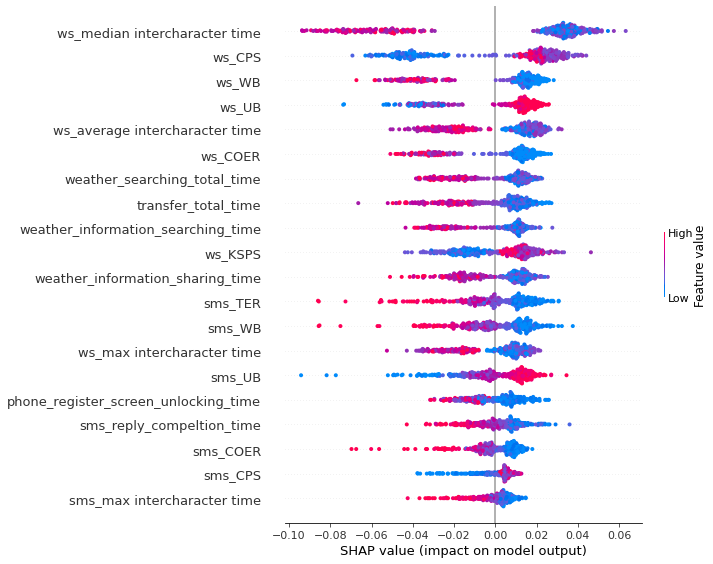

In [47]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[0], X_test, show=False)
    plt.savefig('shap_summaryplot_rf_3label_class0.png', bbox_inches='tight')

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[1], X_test, show=False)
    plt.savefig('shap_summaryplot_rf_3label_class1.png', bbox_inches='tight')

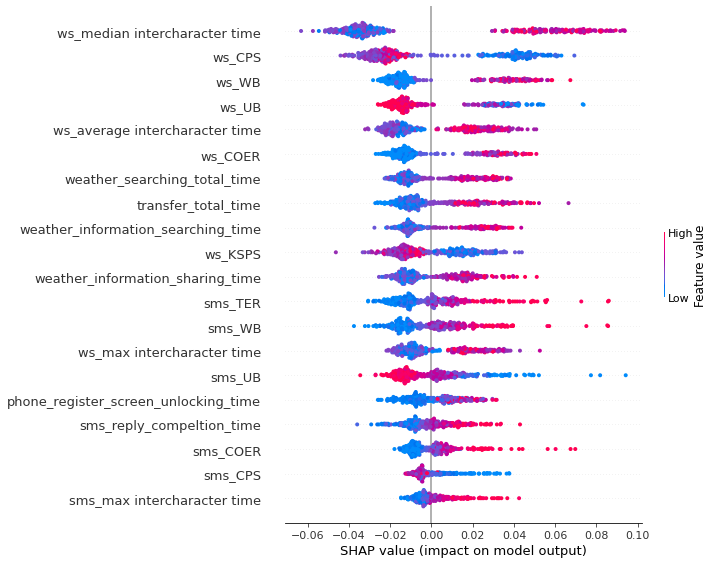

In [48]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[2], X_test, show=False)
    plt.savefig('shap_summaryplot_rf_3label_class2.png', bbox_inches='tight')

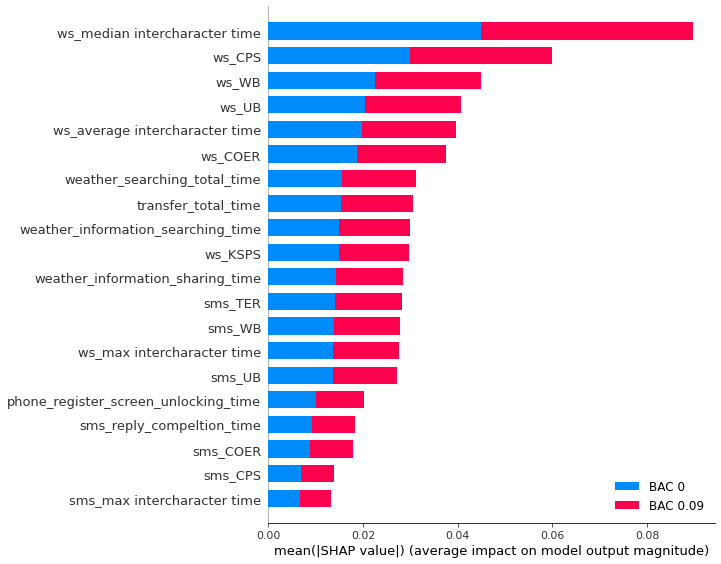

In [49]:
if label_name == 'three_label':
    shap_values = [shap_values[0], shap_values[1], shap_values[2]]
    shap.summary_plot(shap_values, X_test, class_names=['BAL 0', 'BAL 0.03-0.06', 'BAL 0.06-0.09'], class_inds=[0, 1, 2])
    plt.savefig('shap_absmeanplot_rf_3label.png', bbox_inches='tight')

# GBM Bayesian

In [50]:
class GBMObjective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __call__(self, trial: Trial):
        gbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'max_features': trial.suggest_categorical('max_features', [None, 'sqrt']),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1), 
            'random_state': 42
        }

        clf = GradientBoostingClassifier(**gbm_params)

        mean_accuracy = InnerCrossValidation(clf, self.X, self.y, cv_method, n_fold)

        return mean_accuracy

In [51]:
clf = GradientBoostingClassifier(random_state=42)
shap_values, X_test, metric_df = NestedCVwithOptuna(GBMObjective, clf, 'gbm')

[I 2022-08-28 22:24:23,418] A new study created in memory with name: gbm Study


class_nums :  2


[I 2022-08-28 22:24:24,090] Trial 0 finished with value: 0.8005698005698005 and parameters: {'n_estimators': 139, 'learning_rate': 0.031178084281101547, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7, 'subsample': 1.0}. Best is trial 0 with value: 0.8005698005698005.
[I 2022-08-28 22:24:24,177] A new study created in memory with name: gbm Study


Optuna Best score :  0.8005698005698005
test accuracy :  1.0


KeyboardInterrupt: 

## 40개의 모델의 개별 performance metric + 평균 performnace metric을 저장한다
## 각 모델별 test set의 feature에 따른 shap value를 저장한다

In [ ]:
if label_name == 'three_label':
    shap_values_df_0 = pd.DataFrame(shap_values[0], columns=X_test.columns)
    shap_values_df_1 = pd.DataFrame(shap_values[1], columns=X_test.columns)
    shap_values_df_2 = pd.DataFrame(shap_values[2], columns=X_test.columns)

    with pd.ExcelWriter(f"./gbm_result_3_label.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df_0.to_excel(writer, sheet_name="shap_list_0", index=False)
        shap_values_df_1.to_excel(writer, sheet_name="shap_list_1", index=False)
        shap_values_df_2.to_excel(writer, sheet_name="shap_list_2", index=False)

if label_name != 'three_label':
    shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)

    with pd.ExcelWriter(f"./gbm_result_3_label.xlsx") as writer:
        metric_df.to_excel(writer, sheet_name="performance metric", index=False)
        shap_values_df.to_excel(writer, sheet_name="shap_list", index=False)

## 3 Labels

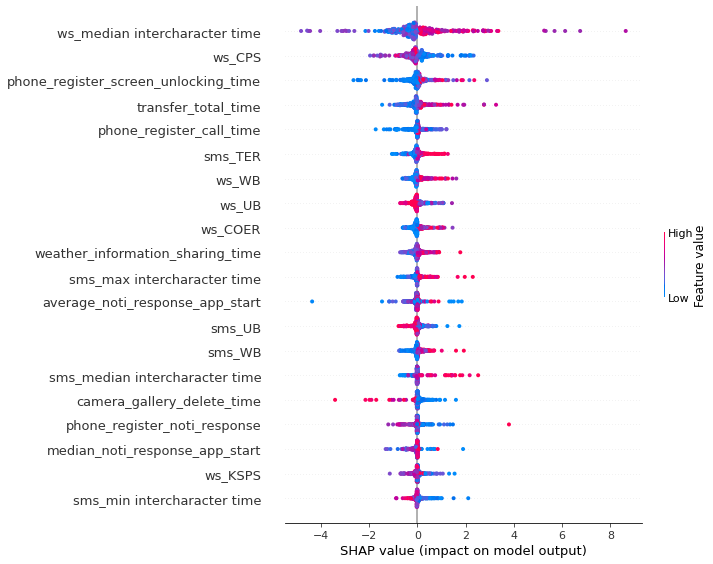

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[0], X_test, show=False)
    plt.savefig('shap_summaryplot_gbm_3label_class0.png', bbox_inches='tight')

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[1], X_test, show=False)
    plt.savefig('shap_summaryplot_gbm_3label_class1.png', bbox_inches='tight')

In [ ]:
if label_name == 'three_label':
    shap.summary_plot(shap_values[2], X_test, show=False)
    plt.savefig('shap_summaryplot_gbm_3label_class2.png', bbox_inches='tight')

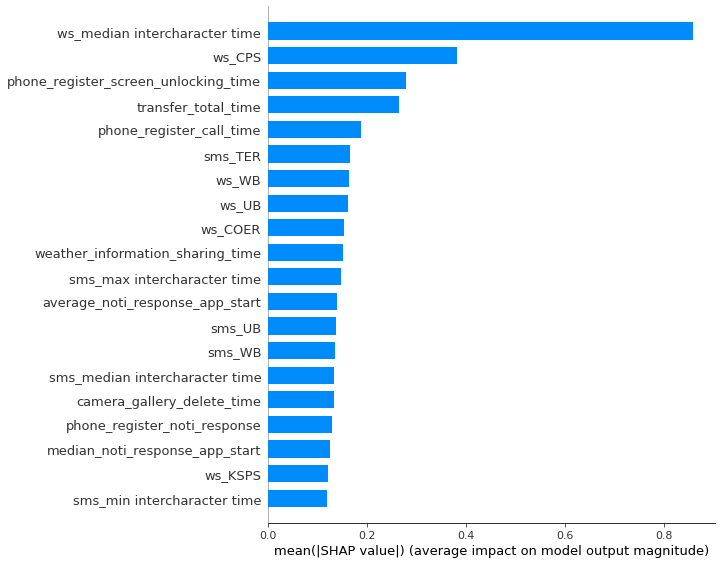

In [ ]:
if label_name == 'three_label':
    shap_values = [shap_values[0], shap_values[1], shap_values[2]]
    shap.summary_plot(shap_values, X_test, class_names=['BAL 0', 'BAL 0.03-0.06', 'BAL 0.06-0.09'], class_inds=[0, 1, 2])
    plt.savefig('shap_absmeanplot_gbm_3label.png', bbox_inches='tight')